Based on [this Jupyter notebook](https://github.com/atomic14/tensorflow-lite-esp32/blob/master/Train%20Model.ipynb).

 - Zip your ./data folder.
 - Upload it to this notebook using the second code cell.
 - Unzip it by running the following cell.

In [1]:
!pip install tensorflow==2.4.0

In [2]:
from google.colab import files
files.upload()

{}

In [3]:
!unzip data.zip

Archive:  data.zip
replace data/noise/pop_0.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [5]:
data_dirs = ["data/pops/", "data/noise/"]
data_weights = [10, 1]
sample_length = 4000
batch_size = 32
sample_rate = 16000
reaction_time = 0.2 # seconds
downsample_factor = 4
kernel_size = 201

In [6]:
def data_generator():
    reaction_timesteps = int(round(reaction_time * sample_rate))
    samples = []
    for data_dir, data_weight in zip(data_dirs, data_weights):
        for i in range(len(os.listdir(data_dir)) // 2):
            sound =  np.load(data_dir + f"sound_{i}.npy").astype(np.float)
            pop =  np.load(data_dir + f"pop_{i}.npy").astype(np.float)

            # reaction shifting + zero padding
            pop = np.concatenate((pop[reaction_timesteps:], np.zeros(reaction_timesteps)))

            for _ in range(data_weight):
                samples.append((sound, pop))

    while True:
        sound, pop = random.choice(samples)
        start_timestep = random.randrange(0, len(sound) - sample_length)
        stop_timestep = start_timestep + sample_length

        sound = sound[start_timestep:stop_timestep] # random segment
        sound = sound.reshape(
            sample_length // downsample_factor, downsample_factor, 1, 1
        ).mean(axis=1) # downsampling

        pop = pop[start_timestep:stop_timestep] # random segment
        pop = pop.reshape(
            sample_length // downsample_factor, downsample_factor,
        ).sum(axis=1) # downsampling

        # cropping to output size
        kernel_radius = (kernel_size - 1) // 2
        pop = pop[kernel_radius:-kernel_radius]

        yield sound, pop
        
# create a dataset from our generator
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    output_signature=(
        tf.TensorSpec(shape=(sample_length // downsample_factor, 1, 1), dtype=tf.float32),
        tf.TensorSpec(shape=((sample_length // downsample_factor) - (kernel_size - 1),), dtype=tf.float32),
    ),
).batch(batch_size)

In [7]:
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean((tf.reduce_sum(y_true, axis=1) - tf.reduce_sum(y_pred, axis=1)) ** 2)

model = keras.models.Sequential([
    layers.InputLayer(input_shape=(sample_length // downsample_factor, 1, 1)),
    layers.Conv2D(filters=1, kernel_size=(kernel_size, 1), activation="relu", kernel_initializer=keras.initializers.truncated_normal(stddev=1e-5)),
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-6),
    loss=mean_squared_error,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 800, 1, 1)         202       
Total params: 202
Trainable params: 202
Non-trainable params: 0
_________________________________________________________________


In [8]:
sounds, true_pops = next(iter(train_dataset))
pred_pops = model.predict(sounds)
print(
    "{:.4f} should be somewhat smaller than {:.4f}. If that is not true, decrease the kernel_initializer's standard deviation.".format(
        tf.reduce_mean(tf.math.reduce_std(pred_pops, axis=1)),
        tf.reduce_mean(tf.math.reduce_std(true_pops, axis=1)),
    )
)

0.0038 should be somewhat smaller than 0.0055. If that is not true, decrease the kernel_initializer's standard deviation.


In [9]:
model.fit(
    train_dataset,
    steps_per_epoch=100,
    epochs=10,
)

Epoch 1/10
100/100 [==============================] - 1s 11ms/step - loss: 1.9492
Epoch 2/10
100/100 [==============================] - 1s 11ms/step - loss: 0.1471
Epoch 3/10
100/100 [==============================] - 1s 11ms/step - loss: 0.1866
Epoch 4/10
100/100 [==============================] - 1s 10ms/step - loss: 0.2356
Epoch 5/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1500
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1601
Epoch 7/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1513
Epoch 8/10
100/100 [==============================] - 1s 11ms/step - loss: 0.1454
Epoch 9/10
100/100 [==============================] - 1s 10ms/step - loss: 1.0594
Epoch 10/10
100/100 [==============================] - 1s 10ms/step - loss: 0.1469


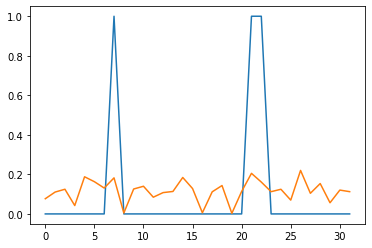

In [10]:
# compare the predictions and the ground truth visually
sounds, true_pops = next(iter(train_dataset))
pred_pops = model.predict(sounds).squeeze()

plt.plot(tf.reduce_sum(true_pops, axis=1))
plt.plot(tf.reduce_sum(pred_pops, axis=1))

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converted_model = converter.convert()
with open('model.tflite', 'wb') as model_file:
  model_file.write(converted_model)


INFO:tensorflow:Assets written to: /tmp/tmposlp2g8s/assets


In [12]:
# install xxd
!apt-get update && apt-get -qq install xxd

# convert model
!xxd -i model.tflite > model.cc

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 